# OOP Research-Based Backtester

## Description
This is a simple backtester implementing the essential components: a data handler, a strategy implementer, a portfolio, and a performance assessment. Execution handler is not implemented here, as we are just testing out how the backtester will work. This will be implemented utilizing Python, NumPy, and Pandas.

Source: https://www.quantstart.com/articles/Research-Backtesting-Environments-in-Python-with-pandas

## Time-Series based Backtester

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import datetime

#Overrides the new Yahoo API so we can still pull remotely from it.
yf.pdr_override()
%matplotlib inline

We will start by creating a strategy abstract base class.

In [4]:
from abc import ABCMeta, abstractmethod

In [5]:
#We declare a Strategy class, which will be abstract, and inheriting from the Object superclass. 
class Strategy(object):
    """Strategy will be utilized as a template for all future inherited trading strategies.
    
    The goal of the Strategy is to output a list of signals, via a Pandas DataFrame, which is then sent to the portfolio."""
    
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def generate_signals(self):
        #Implementation requires to return DataFrame of symbols containing a set of signals, with tertiary values.
        raise NotImplementedError("Implement generate_signals()")

We will continue towards the Portfolio class. It will be in charge of determining risk, transaction costs, execution handling, and establishing an equity curve.

In [7]:
class Portfolio(object):
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def generate_positions(self):
        '''Should be used to determine how portfolio positions are allocated, based on signals and current cash.'''
        raise NotImplementedError("Implement generate_positions()")
    
    @abstractmethod
    def backtest_portfolio(self):
        '''Gives logic to generate trading orders and portfolio equity curve (growth of equity over time)
        and returns.'''
        raise NotImplementedError("Implement backtest_portfolfio()")

## Testing the OOP Backtester

We will implement a Strategy subclass in order to test signal generation.

In [10]:
class RandomForecastingStrategy(Strategy):
    '''Derived from Strategy. Will produce a set of signals randomly.'''
    
    '''Initialize object with a single symbol and Pandas DF of bars'''
    def __init__(self, symbol, bars):
        self.symbol = symbol
        self.bars = bars
        
    '''Create Pandas DF of random signals'''
    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = np.sign(np.random.rand(len(signals)))
        
        # We set first five elements to 0 to minimize upstream NaN errors in forecaster.
        signals['signal'][0:5] = 0.0
        return signals

Now we will implement a basic portfolio class that focuses on going long/short based on open price. It will not take into account transaction costs, specify amount of stock to purchase, and no leverage to greatly simplify it.

In [74]:
class MarketOnOpenPortfolio(Portfolio):
    '''Purchase 100 of particular stock depending on signals giving, based on market open price.
    
    0 Transaction costs, cash will be immediately borrowed for shorting (no leverage/interest).'''
    
    #Initialize object, with single stock symbol, bars (remotely pulled data on symbol), signals generated
    #from strategy, and intial capital (defaulted to $100k if not specified)
    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        '''Generate positions DF that long/shorts 100 of the symbol stock depending on signal value'''
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions[self.symbol] = 100*signals['signal']
        return positions
    
    def backtest_portfolio(self):
        '''Create portfolio from positions dataframe. Calculate total cash and holding (market price of position), and 
        generate both an equity curve and a set of returns'''
        
        #Construct Portfolio using position DF's index, and generate 'Trading Orders' with pos_diff.
        portfolio = pd.DataFrame(index=self.bars.index)
        pos_diff = self.positions.diff()
        
        #Create holdings and cash columns via calculations in trades
        #portfolio['holdings'] = (self.positions*self.bars['Open']).sum(axis=1)
        #portfolio['cash'] = self.initial_capital - (self.positions*self.bars['Open'].cumsum())
        portfolio['holdings'] = self.positions.mul(self.bars['Open'], axis='index')
        portfolio['cash'] = self.initial_capital - portfolio['holdings'].cumsum()
        
        #Figure out total and bar-based returns based on 'cash' and holding' figures of portfolio
        #portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        #portfolio['returns'] = portfolio['total'].pct_change()
        portfolio['total'] = portfolio['cash'] + self.positions[self.symbol].cumsum() * self.bars['Open']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

Now, we will implement and test these classes, with 'SPY' (ETF that tracks index of S&P 500), and pull the data of Yahoo Finance

In [67]:
symbol = 'SPY'
bars = pdr.get_data_yahoo(symbol, start=datetime.datetime(2010, 8, 16), end=datetime.datetime(2017,8,16))

In [68]:
bars.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-08-16,107.570000,108.610001,107.180000,108.260002,93.787773,147895300
2010-08-17,109.190002,110.389999,108.879997,109.589996,94.939964,172270300
2010-08-18,109.540001,110.379997,108.910004,109.790001,95.113228,182922100
2010-08-19,109.220001,109.489998,107.430000,107.879997,93.458565,265847600
2010-08-20,107.559998,107.940002,106.750000,107.529999,93.155373,209714200


In [69]:
strategy = RandomForecastingStrategy(symbol, bars)
signals = strategy.generate_signals()

In [70]:
signals.head(10)

,signal
Date,
2010-08-16,0.0
2010-08-17,0.0
2010-08-18,0.0
2010-08-19,0.0
2010-08-20,0.0
2010-08-23,1.0
2010-08-24,1.0
2010-08-25,1.0
2010-08-26,1.0


In [75]:
portfolio_object = MarketOnOpenPortfolio(symbol, bars, signals)

In [76]:
portfolio = portfolio_object.backtest_portfolio()

In [77]:
portfolio.head(10)

,holdings,cash,total,returns
Date,,,,
2010-08-16,0.0000,100000.0000,100000.0000,NaN
2010-08-17,0.0000,100000.0000,100000.0000,0.000000
2010-08-18,0.0000,100000.0000,100000.0000,0.000000
2010-08-19,0.0000,100000.0000,100000.0000,0.000000
2010-08-20,0.0000,100000.0000,100000.0000,0.000000
2010-08-23,10804.0001,89195.9999,100000.0000,0.000000
2010-08-24,10594.9997,78601.0002,99790.9996,-0.002090
2010-08-25,10494.9997,68106.0005,99590.9996,-0.002004
2010-08-26,10644.0002,57462.0003,100038.0011,0.004488


Now we will plot the equity curve

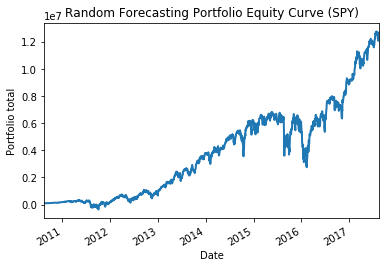

In [82]:
fig = plt.figure()

fig1 = fig.add_subplot(111, ylabel = 'Portfolio total')

portfolio['total'].plot(ax=fig1, lw=2)

plt.title('Random Forecasting Portfolio Equity Curve (SPY)')

# Implementing a simple Moving Average Crossover Strategy

Now, we will take the backbone OOP backtester we have made, and apply it to a Moving Average Crossover Strategy (Momentum-based) utilizing the AAPL security. Implementation: We calculate two separate simple moving averages, with a short and a long lookback period. When the shorter MA exceeds the longer MA, we take a long position; when longer MA exceeds shorter MA, we take a short position. 

Source: https://www.quantstart.com/articles/Backtesting-a-Moving-Average-Crossover-in-Python-with-pandas

We will start with implementing the strategy.

In [87]:
class MovingAverageCrossoverStrat(Strategy):
    '''
    object properties:
    Stock Symbol
    Data Bars (pulled remotely)
    Short lookback window
    Long lookback window
    '''
    def __init__(self, symbol, bars, short_lookback=100, long_lookback=400):
        self.symbol = symbol
        self.bars = bars
        self.short_lookback = 100
        self.long_lookback = 400
    
    #Generate signals Dataframe, {1,0,-1} equivalent to long/hold/sell positions.
    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0
    
        #Calulate the long and short moving averages
        signals['long_moving_avg'] = self.bars['Close'].rolling(self.long_lookback, min_periods=1).mean()
        signals['short_moving_avg'] = self.bars['Close'].rolling(self.short_lookback, min_periods=1).mean()
        
        #Create the signals based on the long and short moving averages
        signals['signal'][self.short_lookback:] = np.where(signals['short_moving_avg'][self.short_lookback:] > 
                                                            signals['long_moving_avg'][self.short_lookback:], 1.0, 0.0)
        
        #Generate the positions based on the signals, to know whether to buy, hold, or sell.
        signals['position'] = signals['signal'].diff()
        
        return signals

In [115]:
class MarketOnClosePortfolio(Portfolio):
    '''Create portfolio, equity curve, and returns based on strategy signals and positions we established earlier.
    Focuses on a single stock only.
    
    Object properties:
    Stock Symbol
    Bars
    Signals DF
    Initial_capital'''
    
    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = initial_capital
        self.positions = self.generate_positions()
    
    #Generate the positions based on signals. Default is buying 100 shares.
    def generate_positions(self):
        positions = pd.DataFrame(index=self.bars.index).fillna(0.0)
        positions = self.signals['signal']*100
        return positions
    
    def backtest_portfolio(self):
        #Construct Portfolio using position DF's index, and generate 'Trading Orders' with pos_diff.
        portfolio = pd.DataFrame(index=self.bars.index)
        pos_diff = self.positions.diff()
        
        #Create holdings and cash columns via calculations in trades
        #portfolio['holdings'] = (self.positions*self.bars['Open']).sum(axis=1)
        #portfolio['cash'] = self.initial_capital - (self.positions*self.bars['Open'].cumsum())
        portfolio['holdings'] = self.positions.mul(self.bars['Close'], axis='index')
        portfolio['cash'] = self.initial_capital - (pos_diff.multiply(self.bars['Close'], axis=0)).cumsum()  
        
        #Figure out total and bar-based returns based on 'cash' and holding' figures of portfolio
        #portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        #portfolio['returns'] = portfolio['total'].pct_change()
        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

In [85]:
symbol = 'AAPL'
bars = pdr.get_data_yahoo(symbol, datetime.datetime(2010,8,17), datetime.datetime(2017,8,18))

In [89]:
strategy = MovingAverageCrossoverStrat(symbol, bars)
signals = strategy.generate_signals()
signals.head(10)

,signal,long_moving_avg,short_moving_avg,position
Date,,,,
2010-08-17,0.0,35.995716,35.995716,NaN
2010-08-18,0.0,36.074287,36.074287,0.0
2010-08-19,0.0,35.948573,35.948573,0.0
2010-08-20,0.0,35.877144,35.877144,0.0
2010-08-23,0.0,35.724572,35.724572,0.0
2010-08-24,0.0,35.483096,35.483096,0.0
2010-08-25,0.0,35.371021,35.371021,0.0
2010-08-26,0.0,35.240358,35.240358,0.0
2010-08-27,0.0,35.160000,35.160000,0.0


Now that we have signals established along with bars of data on the AAPL security, we can plot how it will appear.

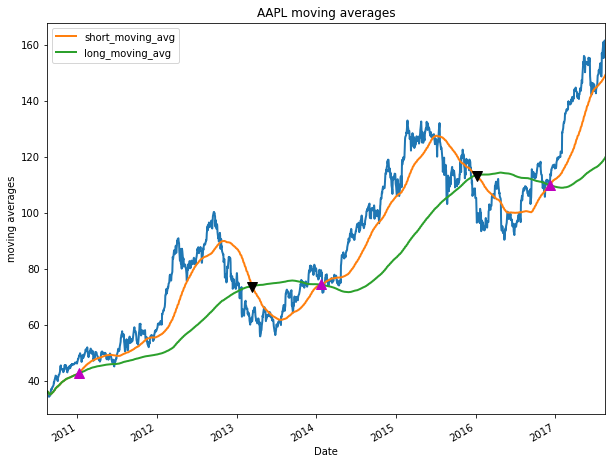

In [104]:
fig = plt.figure(figsize=(10,8))

fig1= fig.add_subplot(111, ylabel='moving averages')

bars['Close'].plot(ax=fig1, lw=2)
signals[['short_moving_avg','long_moving_avg']].plot(ax=fig1, lw=2)

plt.title('AAPL moving averages')

fig1.plot(signals.loc[signals.position == 1.0].index, signals.short_moving_avg[signals.position == 1.0], '^', markersize=10, color='m')
fig1.plot(signals.loc[signals.position == -1.0].index, signals.short_moving_avg[signals.position == -1.0], 'v', markersize=10, color='k')

In [116]:
portfolio = MarketOnClosePortfolio(symbol, bars, signals)
analysis = portfolio.backtest_portfolio()

In [117]:
analysis.tail()

,holdings,cash,total,returns
Date,,,,
2017-08-14,15985.0006,92465.1428,108450.1434,0.002190
2017-08-15,16160.0006,92465.1428,108625.1434,0.001614
2017-08-16,16094.9997,92465.1428,108560.1425,-0.000598
2017-08-17,15786.0001,92465.1428,108251.1429,-0.002846
2017-08-18,15900.0107,92465.1428,108365.1535,0.001053


(98000, 110000)

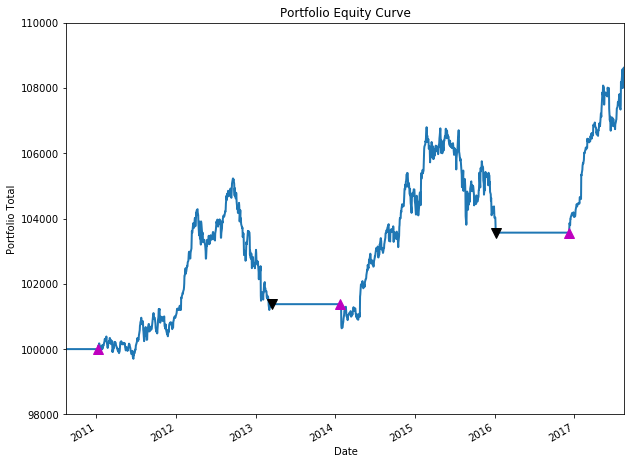

In [132]:
fig = plt.figure(figsize=(10,8))

fig1= fig.add_subplot(111, ylabel='Portfolio Total')

analysis['total'].plot(ax=fig1, lw=2)

plt.title('Portfolio Equity Curve')

fig1.plot(analysis.loc[signals.position == 1.0].index, analysis.total[signals.position == 1.0], '^', markersize=10, color='m')
fig1.plot(analysis.loc[signals.position == -1.0].index, analysis.total[signals.position == -1.0], 'v', markersize=10, color='k')

plt.ylim([98000,110000])